# Linear models, Optimization

基础知识：
1. Two-dimensional classification
2. logistic regression
$$ a(x; w) = \langle w, x \rangle $$
$$ P( y=1 \; \big| \; x, \, w) = \dfrac{1}{1 + \exp(- \langle w, x \rangle)} = \sigma(\langle w, x \rangle)$$

3. loss， cross-entropy
$$ L(w) =  - {1 \over \ell} \sum_{i=1}^\ell \left[ {y_i \cdot log P(y_i \, | \, x_i,w) + (1-y_i) \cdot log (1-P(y_i\, | \, x_i,w))}\right] $$
4. gradients
5. Mini-batch SGD
$$ w_t = w_{t-1} - \eta \dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$

6. SGD with momentum
$$ \nu_t = \alpha \nu_{t-1} + \eta\dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$
$$ w_t = w_{t-1} - \nu_t$$
7. RMSprop
$$ G_j^t = \alpha G_j^{t-1} + (1 - \alpha) g_{tj}^2 $$
$$ w_j^t = w_j^{t-1} - \dfrac{\eta}{\sqrt{G_j^t + \varepsilon}} g_{tj} $$



In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Two-dimensional classification

To make things more intuitive, let's solve a 2D classification problem with synthetic data.

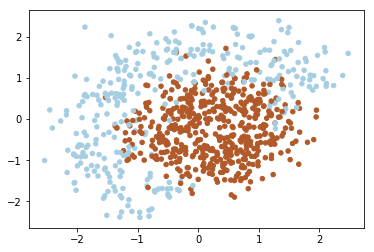

In [3]:
with open('train.npy', 'rb') as fin:
    X = np.load(fin)
    
with open('target.npy', 'rb') as fin:
    y = np.load(fin)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)
plt.show()

# Task

## Features

In [4]:
def expand(X):
    """
    Adds quadratic features. 
    This expansion allows your linear model to make non-linear separation.
    
    For each sample (row in matrix), compute an expanded row:
    [feature0, feature1, feature0^2, feature1^2, feature0*feature1, 1]
    
    :param X: matrix of features, shape [n_samples,2]
    :returns: expanded features of shape [n_samples,6]
    """
    X_expanded = np.zeros((X.shape[0], 6))
    
    # TODO:<your code here>
    X_expanded[:, 0] = X[:, 0]
    X_expanded[:, 1] = X[:, 1]
    X_expanded[:, 2] = np.square(X[:, 0])
    X_expanded[:, 3] = np.square(X[:, 1])
    X_expanded[:, 4] = X[:, 0] * X[:, 1]
    X_expanded[:, 5] = 1
    
    return X_expanded

In [5]:
X_expanded = expand(X)

## Logistic regression


In [6]:
def probability(X, w):
    p = 1.0 / (1.0 + np.exp(- np.dot(X, w)))
    return p

def compute_loss(X, y, w):
    prediction = probability(X, w)
    n_samples = X.shape[0]
    loss = -(np.dot(y, np.log(prediction)) + np.dot(1 - y, np.log(1 - prediction))) / n_samples
    return loss

def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,6], target vector [n_samples] of 1/0,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """
    
    # TODO<your code here>
    prediction = probability(X, w)
    n_samples = X.shape[0]
    dz = prediction - y
    dw = np.dot(dz, X) / n_samples
    return dw

In [7]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

def visualize(X, y, w, history):
    """draws classifier prediction with matplotlib magic"""
    Z = probability(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.subplot(1, 2, 2)
    plt.plot(history)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

## Training
In this section we'll use the functions you wrote to train our classifier using stochastic gradient descent.

You can try change hyperparameters like batch size, learning rate and so on to find the best one, but use our hyperparameters when fill answers.

## Mini-batch SGD

Stochastic gradient descent just takes a random example on each iteration, calculates a gradient of the loss on it and makes a step:
$$ w_t = w_{t-1} - \eta \dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$



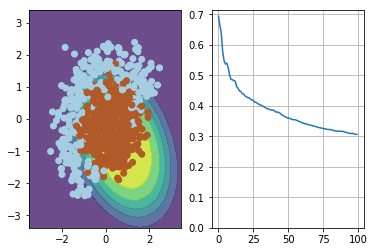

<Figure size 432x288 with 0 Axes>

In [8]:
# please use np.random.seed(42), eta=0.1, n_iter=100 and batch_size=4 for deterministic results

np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta= 0.1 # learning rate

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss)

    # TODO:<your code here>
    dw = compute_grad(X_expanded[ind, :], y[ind], w)
    w = w - eta * dw
    

visualize(X, y, w, loss)
plt.clf()

## SGD with momentum

Momentum is a method that helps accelerate SGD in the relevant direction and dampens oscillations as can be seen in image below. It does this by adding a fraction $\alpha$ of the update vector of the past time step to the current update vector.
<br>
<br>

$$ \nu_t = \alpha \nu_{t-1} + \eta\dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$
$$ w_t = w_{t-1} - \nu_t$$

<br>


![](sgd.png)


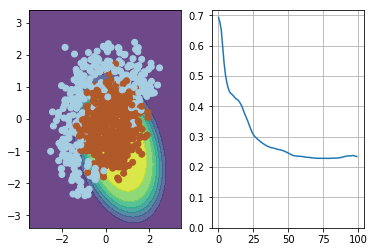

<Figure size 432x288 with 0 Axes>

In [9]:
# please use np.random.seed(42), eta=0.05, alpha=0.9, n_iter=100 and batch_size=4 for deterministic results
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.05 # learning rate
alpha = 0.9 # momentum
nu = np.zeros_like(w)

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss)

    # TODO:<your code here>
    dw = compute_grad(X_expanded[ind, :], y[ind], w)
    nu = alpha * nu + eta * dw
    w = w - nu

visualize(X, y, w, loss)
plt.clf()

## RMSprop

Implement RMSPROP algorithm, which use squared gradients to adjust learning rate:

$$ G_j^t = \alpha G_j^{t-1} + (1 - \alpha) g_{tj}^2 $$
$$ w_j^t = w_j^{t-1} - \dfrac{\eta}{\sqrt{G_j^t + \varepsilon}} g_{tj} $$

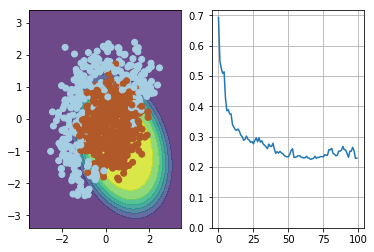

<Figure size 432x288 with 0 Axes>

In [10]:
# please use np.random.seed(42), eta=0.1, alpha=0.9, n_iter=100 and batch_size=4 for deterministic results
np.random.seed(42)

w = np.array([0, 0, 0, 0, 0, 1.])

eta = 0.1 # learning rate
alpha = 0.9 # moving average of gradient norm squared
g2 = 0
eps = 1e-8

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss)

    # TODO:<your code here>
    dw = compute_grad(X_expanded[ind, :], y[ind], w)
    g2 = alpha * g2 + (1 - alpha) * (dw * dw)
    w = w - eta * dw / (np.sqrt(g2) + eps)
    
visualize(X, y, w, loss)
plt.clf()